In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import cv2

from torchvision import transforms
from PIL import Image
%matplotlib inline

### Loading image

In [2]:
path = '1.jpg'
img = transforms.PILToTensor()(Image.open(path)).unsqueeze(0)/255 #grayscale transform

In [3]:
# for notebook only
def pretty_plot(*tensors):
    if len(tensors) > 1:
        _, ax = plt.subplots(1, len(tensors), figsize=(10, 10))
        for i, tensor in enumerate(tensors):
            img = tensor[0] if tensor.ndim == 4 else tensor        
            ax[i].imshow(img.permute(1, 2, 0))
            ax[i].axis('off')
    else:
        fig = plt.figure(figsize=(10, 10))
        tensor = tensors[0]
        img = tensor[0] if tensor.ndim == 4 else tensor
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')

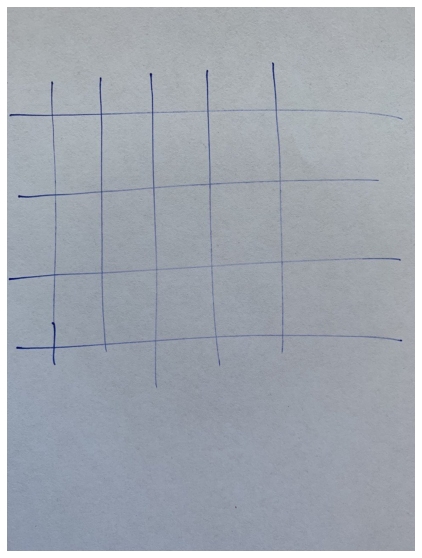

In [4]:
pretty_plot(img)

### Using a single convolution to detect horizontal lines

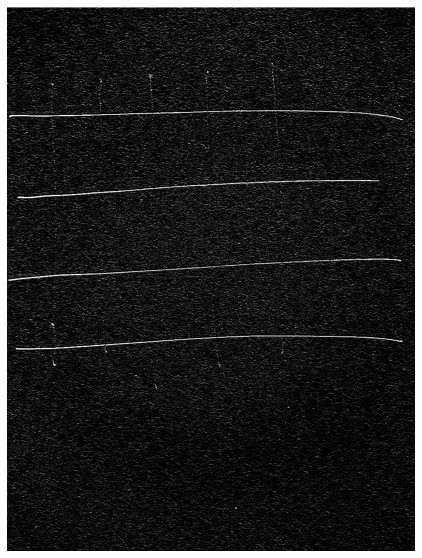

In [5]:
# make kernel to detect horizontal lines
kernel = (torch.ones(3, 3, 3, 3) * torch.tensor([-1, 0, 1])).mT
convolved = F.conv2d(img, kernel, padding='same').clamp(0, 1)
pretty_plot(convolved)

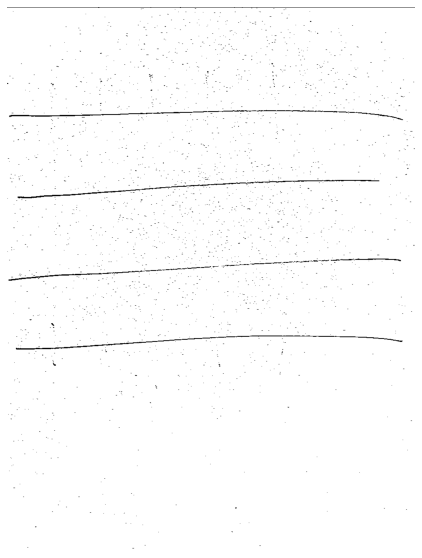

In [6]:
#make binary mask
threshold = 0.6
clamped = (convolved < threshold).to(float)
pretty_plot(clamped)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


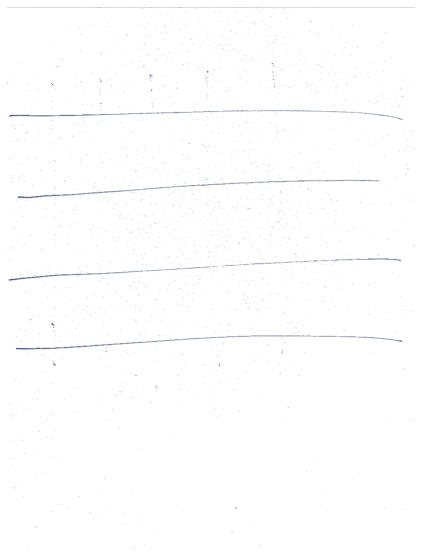

In [7]:
pretty_plot(img+clamped)

### Improving the result by using dilatons, erosions and pooling from OpenCV

The alternative idea is to detect vertical lines, dilate the corresponding pixels and apply cv2.MORPH_OPEN to make a cleaner binary mask. 

Next, we are left with the image with prominent white lines. I propose 2 options:
1. apply average pooling with a narrow window of height 1 to blend the still present vertical white lines with the background

2. (for even better results) apply cv2.MORPH_CLOSE removing the remaining noise

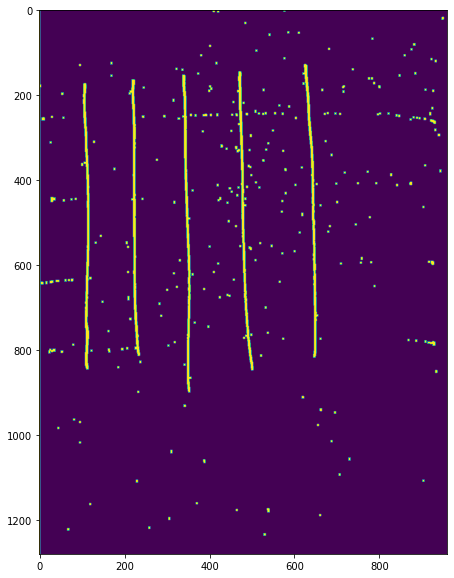

In [8]:
# convolution with vertical edge detector kernel
kernel = torch.ones(3, 3, 3, 3) * torch.tensor([-1, 0, 1])
convolved = F.conv2d(img, kernel, padding='same').clamp(0, 1)
threshold = 0.6
clamped = (convolved > threshold).to(float)
# use dilation from cv2 to dilate the brightest pixels
ks = 5
kernel = np.ones((ks,ks),np.uint8)
dilation = cv2.dilate(clamped[0, 0, :, :].numpy(),kernel,iterations = 1)
fig = plt.figure(figsize=(10, 10))
plt.imshow(dilation)

In [9]:
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,20))
detected_lines = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
mask = torch.tensor(np.asarray([detected_lines]*3)).unsqueeze(0)
clean = (img + mask).clamp(0, 1).float()

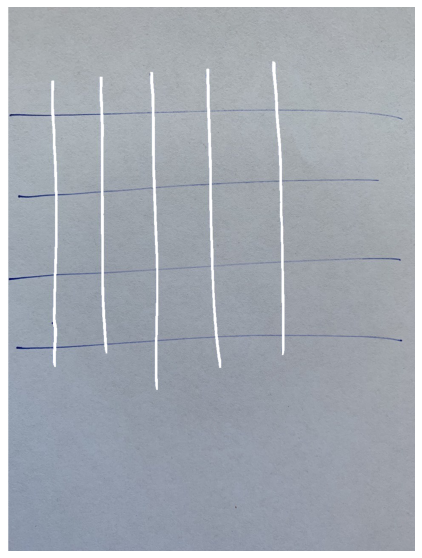

In [10]:
pretty_plot(clean)

#### Removing white lines - average pooling 

torch.Size([1, 3, 1280, 960])


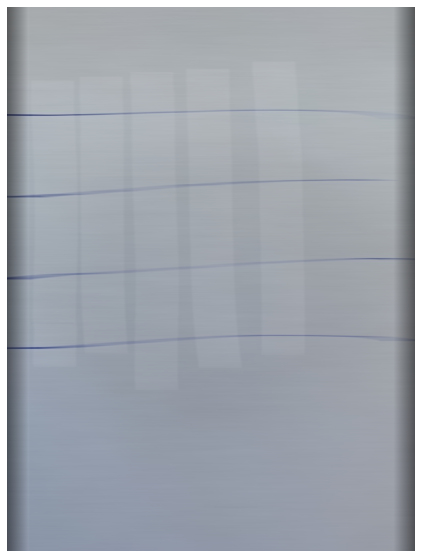

In [11]:
p_ks = 101
pooled = F.avg_pool2d(clean, (1, p_ks), stride=1, padding=(0, p_ks//2))
print(pooled.shape)
pretty_plot(pooled)

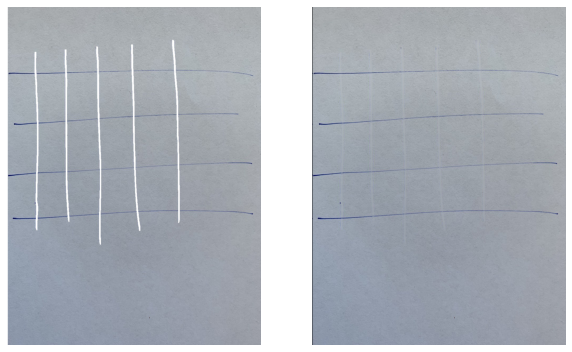

In [12]:
new = clean.float().clone()
new[new==1.] = pooled[new==1.]
pretty_plot(clean, new) 

#### Removing white lines - MORPH_CLOSE

In [13]:
def to_numpy(tensor_img):
    return tensor_img[0].permute(1, 2, 0).numpy()

def to_tensor(result):
    patch = torch.tensor(result)
    return patch.permute(2, 0, 1).unsqueeze(0)

(-0.5, 959.5, 1279.5, -0.5)

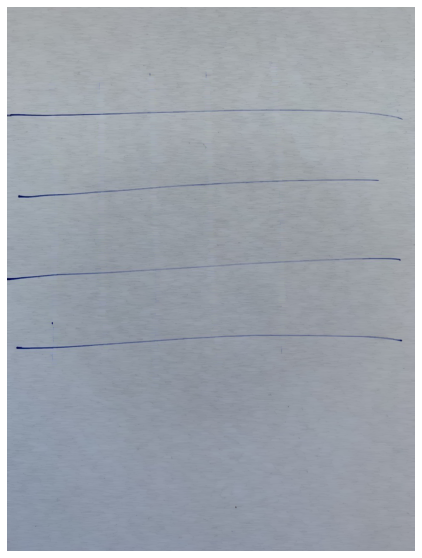

In [14]:
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,1))
result = 255 - cv2.morphologyEx(255 - to_numpy(clean), cv2.MORPH_CLOSE, repair_kernel, iterations=1)
fig = plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.axis('off')